In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mne
from mne.preprocessing import ICA, create_ecg_epochs

from mne_bids import read_raw_bids
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

#### Importing data from subject 1

In [3]:
!ls

BioSemi64Alpha.loc.tsv   README.md                data_exploration_2.ipynb
LICENSE                  data_exploration.ipynb   rawdata


In [2]:
raw_path = 'rawdata/bidsexport/'
raw_fname = 'rawdata/bidsexport/sub-001/ses-02/eeg/sub-001_ses-02_task-meditation_eeg.bdf'

raw = mne.io.read_raw_bdf(raw_fname, montage='./BioSemi64Alpha.loc')
# raw.set_montage('BioSemi64Alpha.loc')

Extracting EDF parameters from /Users/yuyang.zhong/eeg/rawdata/bidsexport/sub-001/ses-02/eeg/sub-001_ses-02_task-meditation_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-2-b0a54a0a2806>:4: DeprecationWarning: Using str in montage different from the built in templates  (i.e. a path) is deprecated. Please choose the proper reader to load your montage using:  ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack``
  raw = mne.io.read_raw_bdf(raw_fname, montage='./BioSemi64Alpha.loc')
/usr/local/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)


ValueError: Could not find the montage. Please provide the full path.

#### Printing subject 1 meta data

In [69]:
print(raw)
print(raw.info)

<RawEDF  |  sub-001_ses-02_task-meditation_eeg.bdf, n_channels x n_times : 80 x 695552 (2717.0 sec), ~162 kB, data not loaded>
<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | A1, A2, A3, A4, A5, A6, A7, A8, A9, ...
    chs : list | 80 items (EEG: 79, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 52.0 Hz
    meas_date : tuple | 2014-04-04 20:30:06 GMT
    nchan : int | 80
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 256.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : No

#### Showing power spectral density (PSD) & raw sensor traces

Effective window size : 8.000 (s)


<ipython-input-114-39c7c24b7f61>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=raw.info['ch_names'][:64])


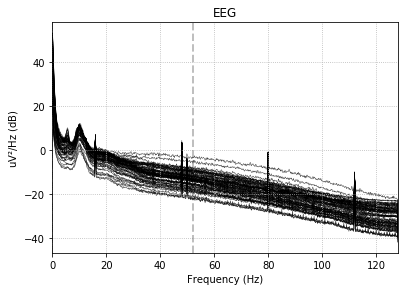

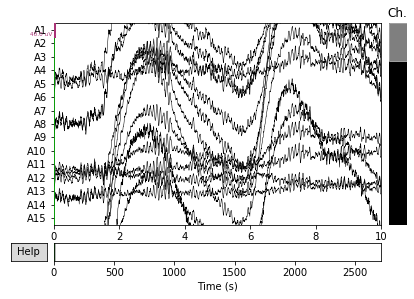

In [114]:
raw.plot_psd(picks=raw.info['ch_names'][:64])
raw.plot(duration=10, n_channels=15);

#### Looking at events

In [71]:
events = mne.find_events(raw, stim_channel='Status')
print(events[:5])

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
101 events found
Event IDs: [  2   4 128]
[[27119     0   128]
 [27894     0     4]
 [29032     0     2]
 [34715     0   128]
 [35523     0     2]]


In [90]:
event_dict = {'Response 1 (this may be a response to question 1, 2 or 3)': 2,
                 'Response 2 (this may be a response to question 1, 2 or 3)': 4,
                 'First question onset (most important marker)': 128}

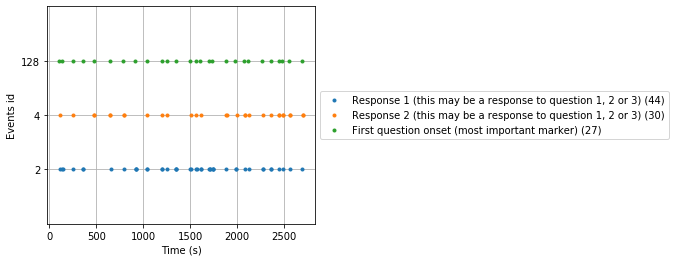

In [91]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'])
fig.subplots_adjust(right=0.7)  # make room for the legend

#### Epoching continuous data

In [93]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5, preload=True)

101 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 101 events and 180 original time points ...
0 bad epochs dropped


In [106]:
conds_we_care_about = ['Response 1 (this may be a response to question 1, 2 or 3)',
                       'Response 2 (this may be a response to question 1, 2 or 3)',
                      'First question onset (most important marker)']
epochs.equalize_event_counts(conds_we_care_about)

Dropped 6 epochs


(<Epochs  |   81 events (all good), -0.199219 - 0.5 sec, baseline [None, 0], ~9.1 MB, data loaded,
  'First question onset (most important marker)': 27
  'Response 1 (this may be a response to question 1, 2 or 3)': 27
  'Response 2 (this may be a response to question 1, 2 or 3)': 27>,
 array([54, 65, 69, 78, 82, 86]))

27 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<ipython-input-136-a4b864a1b27e>:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  r1_epochs.plot_image(picks=['A2'])


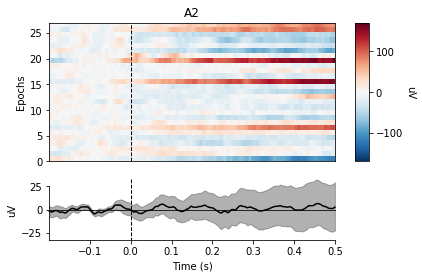

[<Figure size 432x288 with 3 Axes>]

In [136]:
r1_epochs = epochs['Response 1 (this may be a response to question 1, 2 or 3)']
r2_epochs = epochs['Response 2 (this may be a response to question 1, 2 or 3)']
onset_epochs = epochs['First question onset (most important marker)']
r1_epochs.plot_image(picks=['A2'])

#### Time frequency analysis

No baseline correction applied


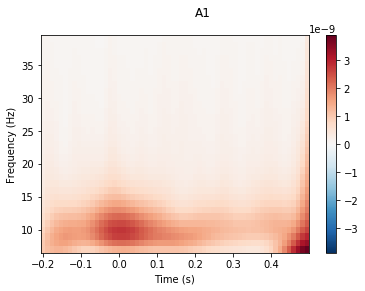

In [135]:
frequencies = np.arange(7, 40, 1)
power = mne.time_frequency.tfr_morlet(r1_epochs, n_cycles=3, return_itc=False,
                                      freqs=frequencies, decim=3)
power.plot(['A1']);

#### evoked response

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


<ipython-input-138-c61520f370fb>:6: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  legend='upper left', show_sensors='upper right')


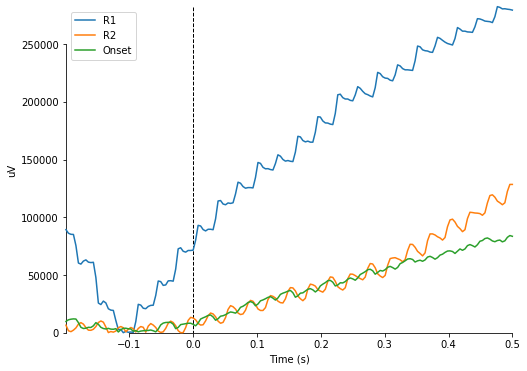

[<Figure size 576x432 with 1 Axes>]

In [138]:
r1_evoked = r1_epochs.average()
r2_evoked = r2_epochs.average()
onset_evoked = onset_epochs.average()

mne.viz.plot_compare_evokeds(dict(R1=r1_evoked, R2=r2_evoked, Onset=onset_evoked),
                             legend='upper left', show_sensors='upper right')

<ipython-input-142-c85f7db7f487>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  r1_evoked.plot_joint(picks='eeg')


RuntimeError: No digitization points found.

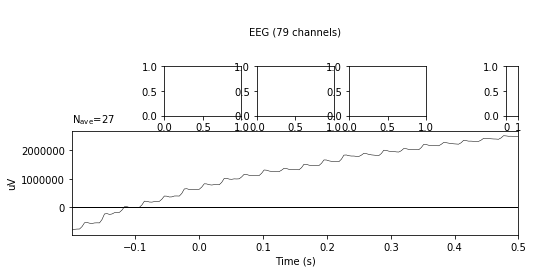

In [142]:
r1_evoked.plot_joint(picks='eeg')
# r1_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg')

In [ ]:
evoked_diff = mne.combine_evoked([aud_evoked, -vis_evoked], weights='equal')
evoked_diff.pick_types('mag').plot_topo(color='r', legend=False)